In [697]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
import matplotlib as mpl

from sklearn.linear_model import LinearRegression, Perceptron, SGDClassifier, LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, RobustScaler

from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve

import warnings
import itertools
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Пример замены missing values c помощью множественной линейной регрессии

In [698]:
age = pd.Series([23, 20, 44, np.nan, 33, np.nan, 45, np.nan, 24], name = 'Age')
series1 = pd.Series(['f', 'm', 'f', 'm', 'f', 'm', 'f', 'f', 'f'], name = 'Sex')
series2 = pd.Series([3219, 2215, 2457, 3333, 1231, 1305, 2078, 990, 2044], name = 'Salary')

dataframe_testing = pd.concat([age, series1, series2], axis = 1)
dataframe_testing

,Age,Sex,Salary
0,23.000,f,3219
1,20.000,m,2215
2,44.000,f,2457
3,NaN,m,3333
4,33.000,f,1231
5,NaN,m,1305
6,45.000,f,2078
7,NaN,f,990
8,24.000,f,2044


In [699]:
encoder = OrdinalEncoder()
dataframe_testing.Sex = encoder.fit_transform(dataframe_testing.Sex.values.reshape(-1,1))
dataframe_testing

,Age,Sex,Salary
0,23.000,0.000,3219
1,20.000,1.000,2215
2,44.000,0.000,2457
3,NaN,1.000,3333
4,33.000,0.000,1231
5,NaN,1.000,1305
6,45.000,0.000,2078
7,NaN,0.000,990
8,24.000,0.000,2044


In [700]:
reg = LinearRegression().fit(dataframe_testing.query('Age > 0').iloc[:,1:], 
                             dataframe_testing.query('Age > 0').Age)

In [701]:
predicting = dataframe_testing[dataframe_testing['Age'].isna()]
predicting.iloc[:,1:]

,Sex,Salary
3,1.000,3333
5,1.000,1305
7,0.000,990


In [702]:
predict_na = reg.predict(predicting.iloc[:,1:]).astype('int')
predict_na

array([16, 23, 38])

In [703]:
dataframe_testing.loc[dataframe_testing['Age'].isna(),'Age'] = predict_na
dataframe_testing

,Age,Sex,Salary
0,23.000,0.000,3219
1,20.000,1.000,2215
2,44.000,0.000,2457
3,16.000,1.000,3333
4,33.000,0.000,1231
5,23.000,1.000,1305
6,45.000,0.000,2078
7,38.000,0.000,990
8,24.000,0.000,2044


# Выполнение задания

In [704]:

# 1. Perform exploratory data analysis (EDA), describe any finding/insights
# 2. Build any classification model, evaluate model performance. 


In [705]:
df = pd.read_csv('C:/Users/LT17/Python/Auxiliary/bank-full.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# 1. Exploratory Data Analysis

In [706]:
df.isna().any() # Пропущенные значения отсутствуют. 

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [707]:

# В случае, если бы были обнаружены пропущенные значения, 
# в зависимости от объёма выборки и ряда обстоятельств,
# было бы как минимум 3 варианта развития событий:
    
#     1. Удалить строки с пропущенными значениями (Нежелательно);
#     2. Заменить средними значениями по выборке (Нежелательно);
#     3. Построить линейную регрессию / knn / random forest по имеющимся в выборке переменным. 
#     Данный способ позволит учитывать взаимосвязи между переменными. 
#     Это гораздо более точный способ, 
#     чем просто замена средними значениями. Пример такого способа приведен в начале данного notebook'a.


In [708]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

# Удалим дублирующиеся строки, если они есть

In [709]:
df.shape[0]

45211

In [710]:
df = df.drop_duplicates(subset = df.columns[:-1].values, keep=False)
df.shape[0]

45211

In [711]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.000,40.936,10.619,18.000,33.000,39.000,48.000,95.000
balance,45211.000,1362.272,3044.766,-8019.000,72.000,448.000,1428.000,102127.000
day,45211.000,15.806,8.322,1.000,8.000,16.000,21.000,31.000
duration,45211.000,258.163,257.528,0.000,103.000,180.000,319.000,4918.000
campaign,45211.000,2.764,3.098,1.000,1.000,2.000,3.000,63.000
pdays,45211.000,40.198,100.129,-1.000,-1.000,-1.000,-1.000,871.000
previous,45211.000,0.580,2.303,0.000,0.000,0.000,0.000,275.000


In [712]:
df.describe().columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

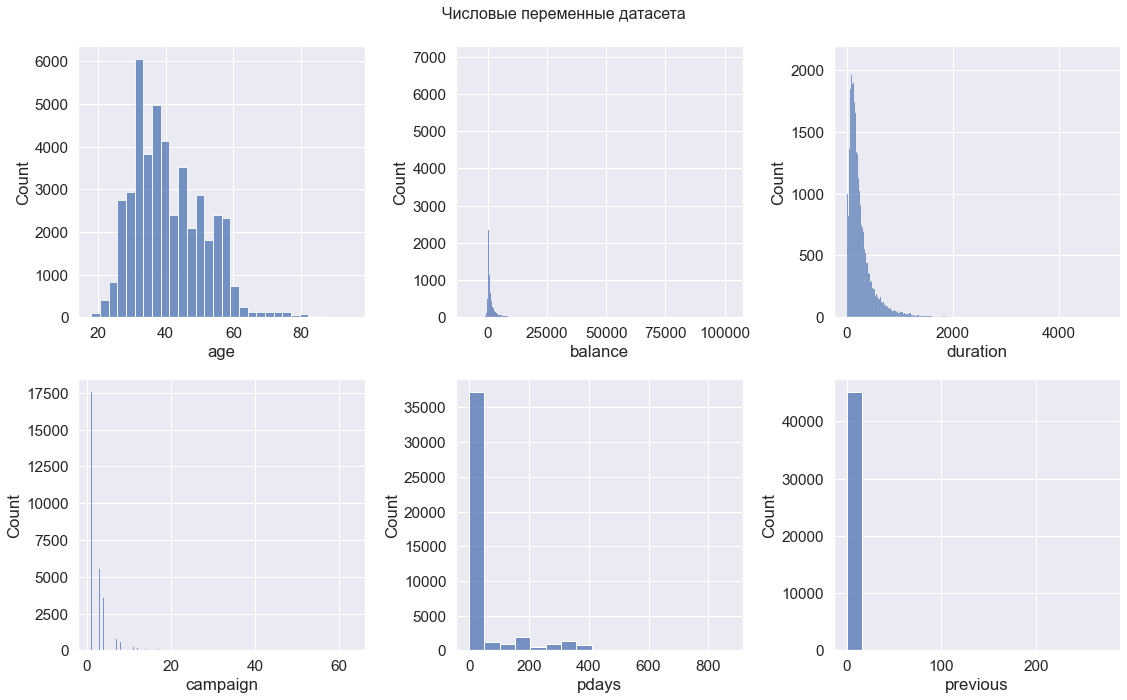

In [713]:
fig, axes = plt.subplots(2, 3, sharex=False, figsize=(16,10))
fig.suptitle('Числовые переменные датасета', fontsize = 16)
sns.set(font_scale=1.5)
sns.histplot(ax=axes[0, 0], data=df, x=df.age, bins = 30)
sns.histplot(ax=axes[0, 1], data=df, x=df.balance)
sns.histplot(ax=axes[0, 2], data=df, x=df.duration)
sns.histplot(ax=axes[1, 0], data=df, x=df.campaign)
sns.histplot(ax=axes[1, 1], data=df, x=df.pdays)
sns.histplot(ax=axes[1, 2], data=df, x=df.previous)

# fig.delaxes(axes[2][1])
# fig.delaxes(axes[2][2])

fig.tight_layout()
plt.show()

In [714]:
df.rename(columns={'y': 'deposit'}, inplace = True)

# Матрица по паре "семейное положение" - "образование"

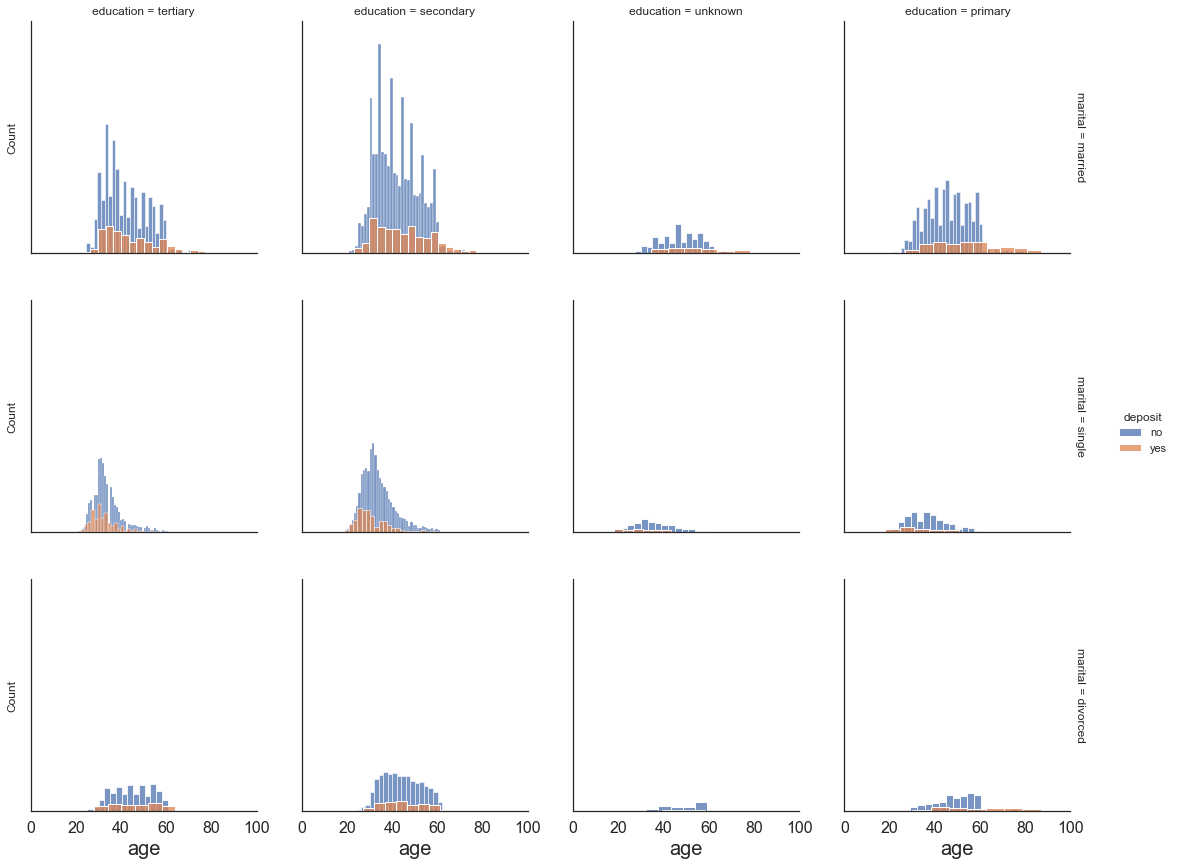

In [715]:
sns.set(rc = {'figure.figsize':(13,10)})

with sns.axes_style("white"):
    g = sns.FacetGrid(df, row="marital",
                      col="education",
                      margin_titles=True, 
                      height=2.9, 
                      hue = 'deposit',
                      size=4, sharey = True)
    
# sns.set(font_scale=1.2)
# g.xlabel(fontsize=30)
g.map(sns.histplot, 'age')
g.figure.subplots_adjust(wspace=.2, hspace=.2)
g.add_legend()
g.set_yticklabels(size = 15)
g.set_xticklabels(size = 16)
g.set_xlabels(size = 20)
plt.show()

# Матрица по паре кредит - семейное положение

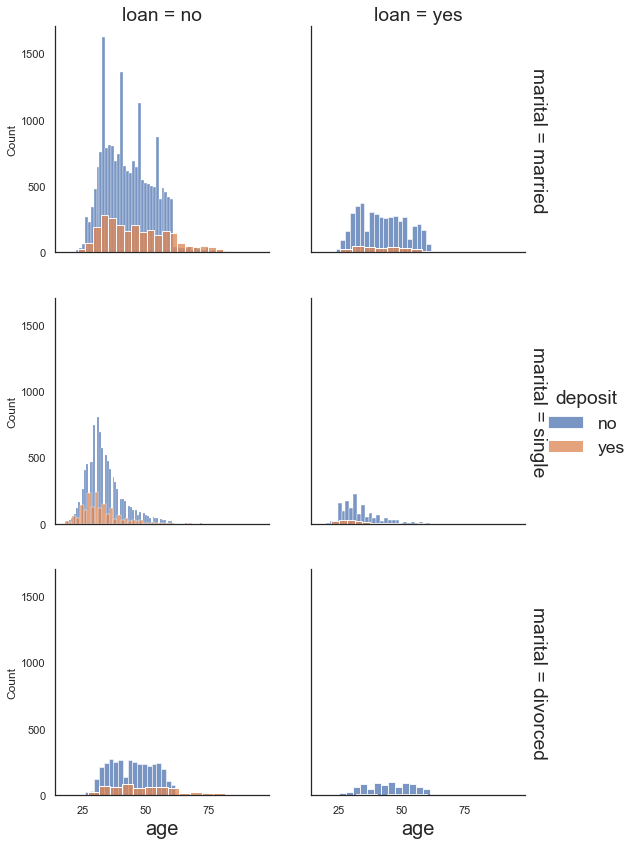

In [716]:
sns.set(rc = {'figure.figsize':(13,10)})

with sns.axes_style("white"):
    g = sns.FacetGrid(df, row="marital",
                      col="loan",
                      margin_titles=True, 
                      height=2.9, 
                      hue = 'deposit',
                      size=4, sharey = True)
    
sns.set(font_scale=1.6)
# g.xlabel(fontsize=30)
g.map(sns.histplot, 'age')
g.figure.subplots_adjust(wspace=.2, hspace=.2)
g.add_legend()
# g.set_yticklabels(size = 15)
# g.set_xticklabels(size = 16)
g.set_xlabels(size = 20)
        
plt.show()

# Матрица по паре кредит - есть ли своё жильё

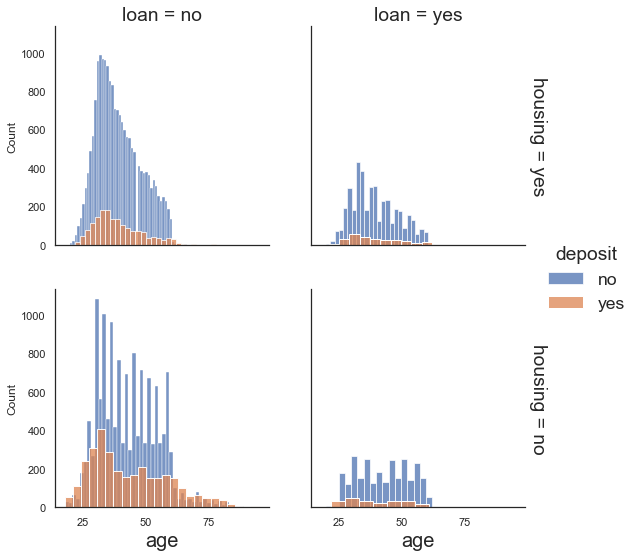

In [717]:
sns.set(rc = {'figure.figsize':(13,10)})

with sns.axes_style("white"):
    g = sns.FacetGrid(df, row="housing",
                      col="loan",
                      margin_titles=True, 
                      height=2.9, 
                      hue = 'deposit',
                      size=4, sharey = True)
    
sns.set(font_scale=1.6)
# g.xlabel(fontsize=30)
g.map(sns.histplot, 'age')
g.figure.subplots_adjust(wspace=.2, hspace=.2)
g.add_legend()
# g.set_yticklabels(size = 15)
# g.set_xticklabels(size = 16)
g.set_xlabels(size = 20)
        
plt.show()

# Cоздаём столбец с датой (подсмотрел на сайте, что точка отсчёта в выгрузке - 2010 год)

In [718]:
d = {'jan': '01', 
     'feb':'02', 
     'mar':'03',
     'apr': '04', 
     'may':'05', 
     'jun':'06',
     'jul': '07', 
     'aug':'08', 
     'sep':'09',
     'oct': '10', 
     'nov':'11', 
     'dec':'12'}

df['month'] = df['month'].replace(d, regex=True)

In [719]:
df.month = df.month.astype('int')

df['date'] = df['month'].astype(str) + '-' + df['day'].astype(str)

n = 2010

for i in range(df.shape[0]):
    
    if df.iloc[i,10] - df.iloc[i-1,10] == -11:
        n += 1

    df.iloc[i,-1] = df.iloc[i,-1] + '-' + str(n)
    
df['day'] = df['day'].astype('str').str.zfill(2)
df.date = pd.to_datetime(df.date)


In [720]:
dummies = pd.get_dummies(df.deposit)
df = pd.concat([df, dummies], axis = 1, join = 'inner')

In [721]:
deposit_dynamic = df.groupby('date').agg({"yes": 'sum'}).rename(columns = {'yes': 'deposit'})

# Межквартильный размах по возрасту: от 33 до 48 лет

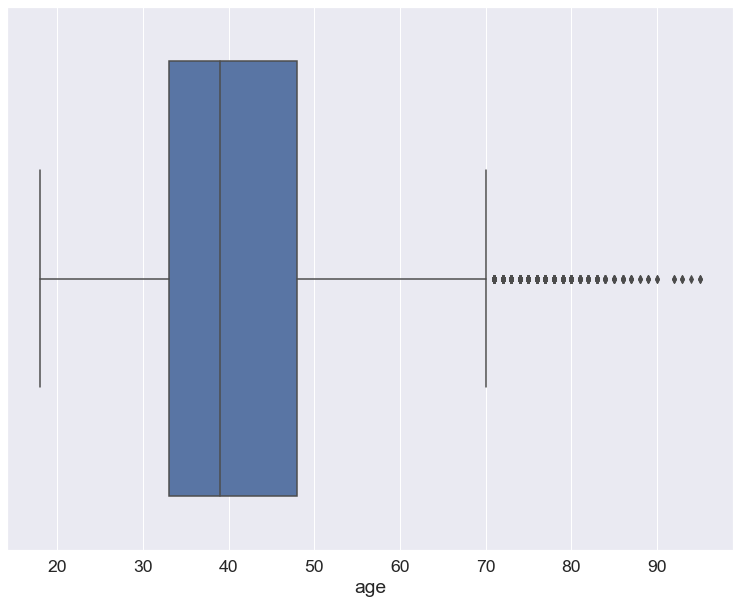

In [722]:
sns.boxplot(data = df, x= df.age)
sns.set(font_scale=1.5)
plt.show()

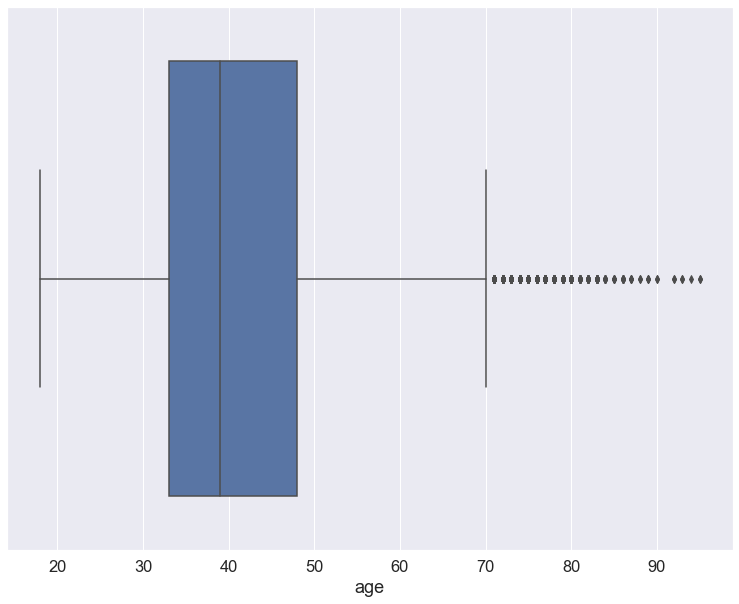

In [723]:
sns.boxplot(data = df.query('deposit =="yes"'), x= df.age)
sns.set(font_scale=1.5)
plt.show()

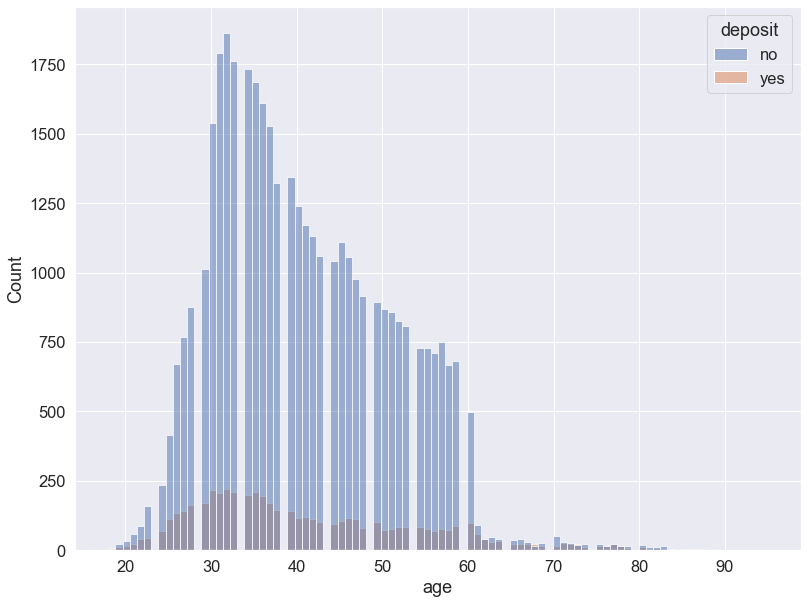

In [724]:
sns.histplot(data = df, x= df.age, hue = 'deposit')
plt.show()

# Функция для автоматических лейблов на столбчатые диаграммы

In [725]:
#_______________________________________________________

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.02)
                value = '{:.1f}%'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + 0.9*float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.4)
                value = '{:.1f}%'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
#_______________________________________________________

In [726]:
jobs2 = df.groupby('job').agg({'yes': 'sum'}) \
                 .astype(int) \
                 .reset_index() \
                 .rename(columns={'yes': 'deposits_subscribed'}) \
                 .sort_values(by = 'deposits_subscribed', ascending = False)

jobs2.replace('admin.', 'admin', inplace = True)

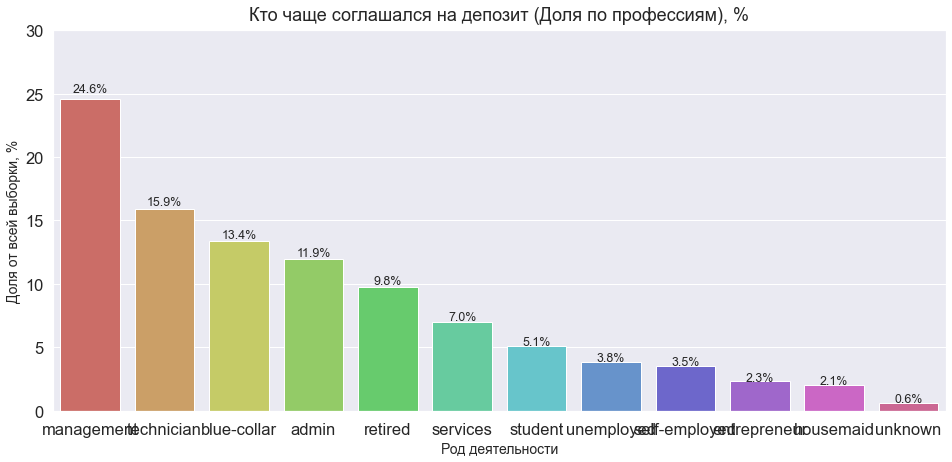

In [727]:
mpl.rcParams['figure.figsize'] = (16.0, 7.0)  


barplot_avg_credit = sns.barplot(x = jobs2.job,
                                 y = 100*jobs2.deposits_subscribed/jobs2.deposits_subscribed.sum(),
                                 palette="hls")

sns.set(font_scale=1.03)
show_values(barplot_avg_credit)

plt.title('',
          fontsize = 16, 
          pad = 16)

plt.ylim(0,30)
barplot_avg_credit.tick_params(axis='x', pad=5)
plt.xlabel('Род деятельности', fontsize=14)
plt.ylabel('Доля от всей выборки, %', fontsize=14)

plt.title('Кто чаще соглашался на депозит (Доля по профессиям), %', 
          fontsize = 18, 
          pad = 10)


plt.show()

In [728]:
jobs = df.groupby(['job', 'education']).agg({'yes': 'sum'}) \
                 .astype(int) \
                 .reset_index() \
                 .rename(columns={'yes': 'deposits_subscribed'})

jobs.replace('admin.', 'admin', inplace = True)

In [729]:
jobs

,job,education,deposits_subscribed
0,admin,primary,12
1,admin,secondary,502
2,admin,tertiary,99
3,admin,unknown,18
4,blue-collar,primary,218
5,blue-collar,secondary,433
6,blue-collar,tertiary,24
7,blue-collar,unknown,33
8,entrepreneur,primary,12
9,entrepreneur,secondary,52


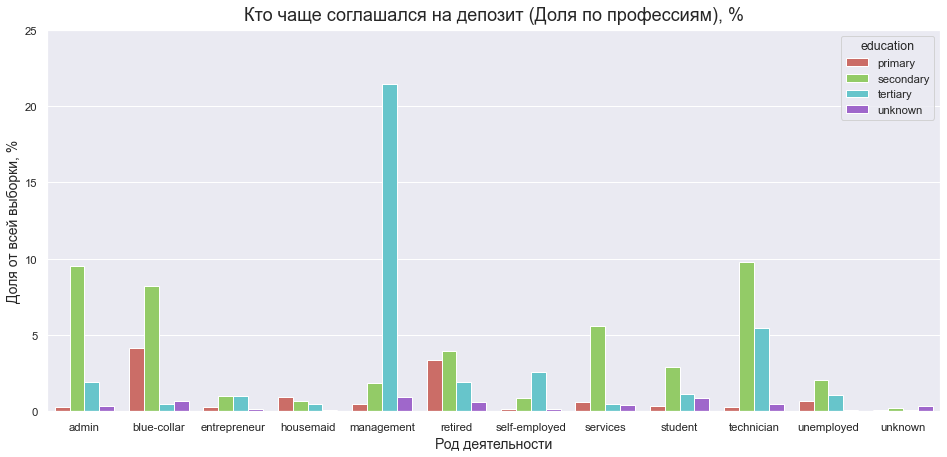

In [730]:
mpl.rcParams['figure.figsize'] = (16.0, 7.0)  


barplot_avg_credit = sns.barplot(x = jobs.job,
                                 y = 100*jobs.deposits_subscribed/jobs.deposits_subscribed.sum(),
                                 palette="hls",
                                 hue = jobs.education)

sns.set(font_scale=1.03)
# show_values(barplot_avg_credit)

plt.title('',
          fontsize = 16, 
          pad = 16)

plt.ylim(0,25)
barplot_avg_credit.tick_params(axis='x', pad=5)
plt.xlabel('Род деятельности', fontsize=14)
plt.ylabel('Доля от всей выборки, %', fontsize=14)

plt.title('Кто чаще соглашался на депозит (Доля по профессиям), %', 
          fontsize = 18, 
          pad = 10)


plt.show()

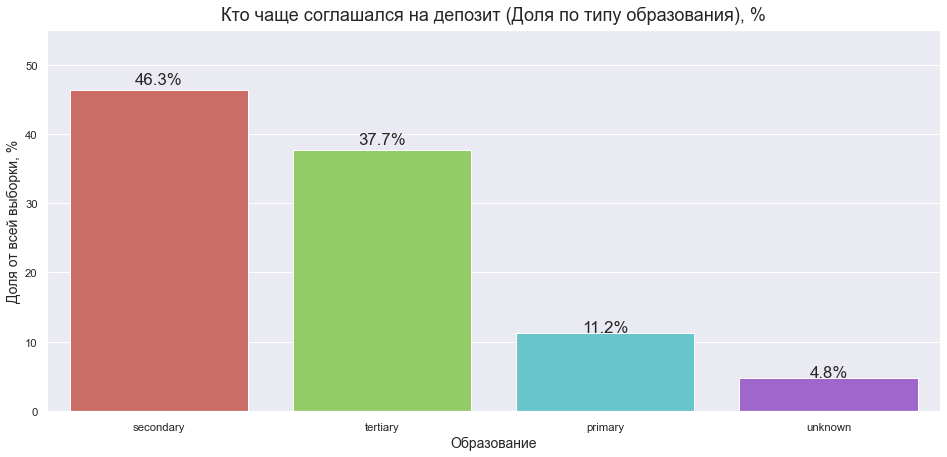

In [731]:
education = df.groupby('education').agg({'yes': 'sum'}) \
                 .astype(int) \
                 .reset_index() \
                 .rename(columns={'yes': 'deposits_subscribed'}) \
                 .sort_values(by = 'deposits_subscribed', ascending = False)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16.0, 7.0)  


barplot_avg_credit = sns.barplot(x = education.education,
                                 y = 100*education.deposits_subscribed/education.deposits_subscribed.sum(),
                                 palette="hls")

sns.set(font_scale=1.4)
show_values(barplot_avg_credit)

plt.title('',
          fontsize = 16, 
          pad = 16)

plt.ylim(0,55)
barplot_avg_credit.tick_params(axis='x', pad=5)
plt.xlabel('Образование', fontsize=14)
plt.ylabel('Доля от всей выборки, %', fontsize=14)

plt.title('Кто чаще соглашался на депозит (Доля по типу образования), %', 
          fontsize = 18, 
          pad = 10)

plt.show()

In [732]:
# Отдельная пандасовская серия под тип связи cellular, которую можно будет потом наложить на график
cellular = df.query('contact == "cellular"').groupby('date').agg({"yes": 'sum'})

cellular = cellular.merge(deposit_dynamic, 
                          how = 'right',
                          left_on = cellular.index, 
                          right_on = deposit_dynamic.index) \
                   .drop(columns = "deposit") \
                   .rename(columns = {"yes": 'cellular',
                                      'key_0': 'date'}) \
                   .set_index('date') \
                   .fillna(0)

# Отдельная пандасовская серия под тип связи telephone, которую можно будет потом наложить на график
telephone = df.query('contact == "telephone"').groupby('date').agg({"yes": 'sum'})

telephone = telephone.merge(deposit_dynamic, 
                          how = 'right',
                          left_on = telephone.index, 
                          right_on = deposit_dynamic.index) \
                   .drop(columns = "deposit") \
                   .rename(columns = {"yes": 'telephone',
                                      'key_0': 'date'}) \
                   .set_index('date') \
                   .fillna(0)


# Отдельная пандасовская серия под тип связи unknown, которую можно будет потом наложить на график
unknown = df.query('contact == "unknown"').groupby('date').agg({"yes": 'sum'})
unknown = unknown.merge(deposit_dynamic, 
                          how = 'right',
                          left_on = unknown.index, 
                          right_on = deposit_dynamic.index) \
                   .drop(columns = "deposit") \
                   .rename(columns = {"yes": 'unknown',
                                      'key_0': 'date'}) \
                   .set_index('date') \
                   .fillna(0)

# Графический анализ привлечения депозита в зависимости от типа связи с клиентом

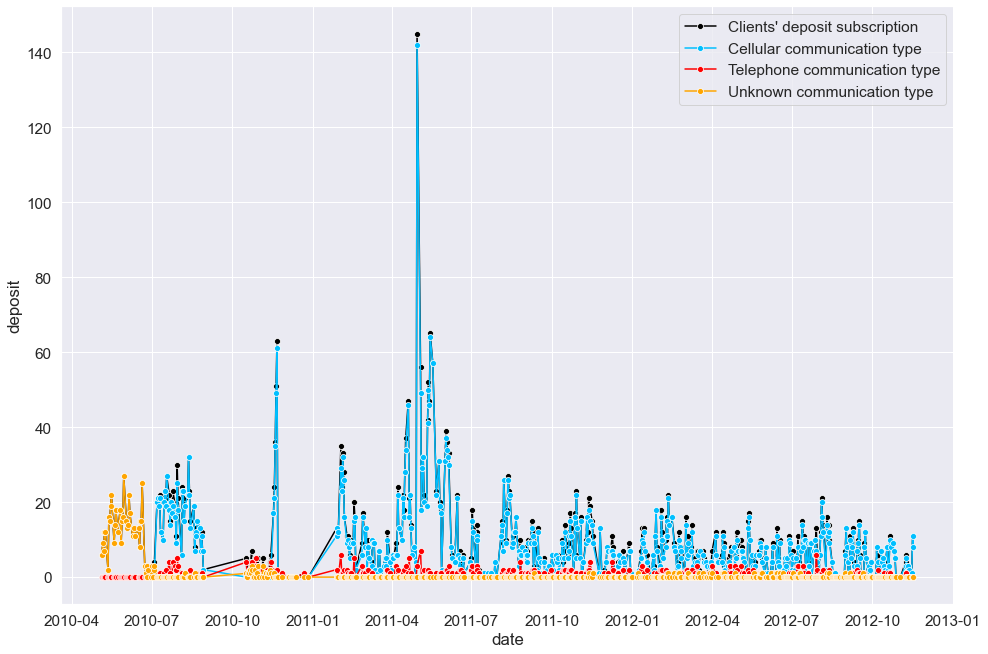

In [733]:
sns.set(rc = {'figure.figsize':(16,11)})
sns.set(font_scale=1.4)

sns.lineplot(data = deposit_dynamic,
             y = deposit_dynamic['deposit'],
             x = deposit_dynamic.index,
             color = 'black',
             marker = 'o',
            label= "Clients' deposit subscription")

sns.lineplot(data = cellular,
             y = cellular.cellular,
             x = cellular.index,
             color = 'deepskyblue',
             marker = 'o',
            label= "Cellular communication type")

sns.lineplot(data = telephone,
             y = telephone.telephone,
             x = telephone.index,
             color = 'red',
             marker = 'o',
            label= "Telephone communication type")

sns.lineplot(data = unknown,
             y = unknown.unknown,
             x = unknown.index,
             color = 'orange',
             marker = 'o',
            label= "Unknown communication type")

plt.show()

In [734]:
contact = df.groupby('contact').agg({'yes': 'sum'}) \
                 .astype(int) \
                 .reset_index() \
                 .rename(columns={'yes': 'deposits_subscribed'}) \
                 .sort_values(by = 'deposits_subscribed', ascending = False)

contact.replace('admin.', 'admin', inplace = True)
contact

,contact,deposits_subscribed
0,cellular,4369
2,unknown,530
1,telephone,390


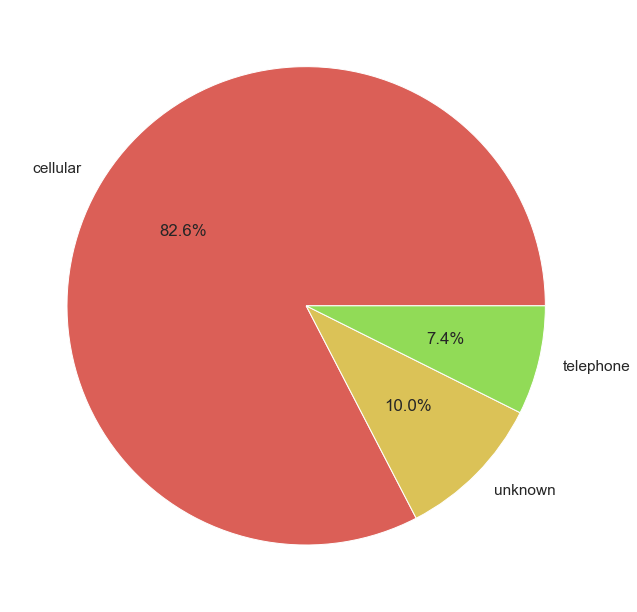

In [735]:
palette_color = sns.color_palette("hls", 8)
  
# plotting data on chart
plt.pie(contact.deposits_subscribed, labels=contact.contact, colors=palette_color, autopct='%.1f%%')
  
# displaying chart
plt.show()

# Переводим категорийные переменные в численные

In [736]:
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
categorical_feats.pop(7)
categorical_feats

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome',
 'deposit']

# Удаляем из выборки столбцы с месяцами, днями

In [737]:
for col in df[categorical_feats]:
        df.loc[:,col] = encoder.fit_transform(df[categorical_feats][col].values.reshape(-1,1))
df.drop(columns = ['yes', 'no', 'day', 'month'], inplace = True)
df

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,deposit,date
0,58,4.000,1.000,2.000,0.000,2143,1.000,0.000,2.000,261,1,-1,0,3.000,0.000,2010-05-05
1,44,9.000,2.000,1.000,0.000,29,1.000,0.000,2.000,151,1,-1,0,3.000,0.000,2010-05-05
2,33,2.000,1.000,1.000,0.000,2,1.000,1.000,2.000,76,1,-1,0,3.000,0.000,2010-05-05
3,47,1.000,1.000,3.000,0.000,1506,1.000,0.000,2.000,92,1,-1,0,3.000,0.000,2010-05-05
4,33,11.000,2.000,3.000,0.000,1,0.000,0.000,2.000,198,1,-1,0,3.000,0.000,2010-05-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,9.000,1.000,2.000,0.000,825,0.000,0.000,0.000,977,3,-1,0,3.000,1.000,2012-11-17
45207,71,5.000,0.000,0.000,0.000,1729,0.000,0.000,0.000,456,2,-1,0,3.000,1.000,2012-11-17
45208,72,5.000,1.000,1.000,0.000,5715,0.000,0.000,0.000,1127,5,184,3,2.000,1.000,2012-11-17
45209,57,1.000,1.000,1.000,0.000,668,0.000,0.000,1.000,508,4,-1,0,3.000,0.000,2012-11-17


In [738]:
df.dtypes

age                   int64
job                 float64
marital             float64
education           float64
default             float64
balance               int64
housing             float64
loan                float64
contact             float64
duration              int64
campaign              int64
pdays                 int64
previous              int64
poutcome            float64
deposit             float64
date         datetime64[ns]
dtype: object

# Обучение и кросс-валидация

In [739]:
X = df.iloc[:,0:-2]
y = df.iloc[:,-2:-1]

X_train, X_valid, y_train, y_valid, = train_test_split(X, y, test_size=0.2, random_state=None)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid,y_valid, test_size=0.4, random_state=None)

# random_state = None отвечает за случайное перемешивание выборок

In [740]:
X_train

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
18214,25,0.000,2.000,1.000,0.000,230,0.000,0.000,1.000,394,14,-1,0,3.000
34816,35,0.000,0.000,1.000,0.000,-101,1.000,1.000,0.000,128,1,-1,0,3.000
41956,43,1.000,1.000,1.000,0.000,14646,0.000,0.000,0.000,210,1,-1,0,3.000
28403,30,0.000,2.000,1.000,0.000,1018,1.000,0.000,0.000,58,1,-1,0,3.000
21180,30,9.000,2.000,2.000,0.000,0,0.000,1.000,1.000,226,3,-1,0,3.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19532,43,4.000,1.000,1.000,0.000,10273,0.000,0.000,0.000,359,2,-1,0,3.000
27248,54,1.000,1.000,0.000,0.000,4503,0.000,0.000,1.000,168,3,-1,0,3.000
25778,57,0.000,0.000,1.000,0.000,18268,1.000,0.000,0.000,68,1,-1,0,3.000
22798,35,9.000,0.000,2.000,0.000,-995,1.000,1.000,0.000,734,4,-1,0,3.000


In [741]:
X_train

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
18214,25,0.000,2.000,1.000,0.000,230,0.000,0.000,1.000,394,14,-1,0,3.000
34816,35,0.000,0.000,1.000,0.000,-101,1.000,1.000,0.000,128,1,-1,0,3.000
41956,43,1.000,1.000,1.000,0.000,14646,0.000,0.000,0.000,210,1,-1,0,3.000
28403,30,0.000,2.000,1.000,0.000,1018,1.000,0.000,0.000,58,1,-1,0,3.000
21180,30,9.000,2.000,2.000,0.000,0,0.000,1.000,1.000,226,3,-1,0,3.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19532,43,4.000,1.000,1.000,0.000,10273,0.000,0.000,0.000,359,2,-1,0,3.000
27248,54,1.000,1.000,0.000,0.000,4503,0.000,0.000,1.000,168,3,-1,0,3.000
25778,57,0.000,0.000,1.000,0.000,18268,1.000,0.000,0.000,68,1,-1,0,3.000
22798,35,9.000,0.000,2.000,0.000,-995,1.000,1.000,0.000,734,4,-1,0,3.000


In [742]:
X_valid

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
344,34,4.000,1.000,2.000,0.000,46,1.000,0.000,2.000,39,4,-1,0,3.000
17744,36,1.000,1.000,0.000,0.000,106,1.000,0.000,0.000,171,13,-1,0,3.000
25994,48,4.000,1.000,2.000,0.000,879,0.000,0.000,0.000,136,3,-1,0,3.000
24744,49,9.000,1.000,3.000,0.000,323,1.000,0.000,0.000,41,2,-1,0,3.000
16824,32,4.000,2.000,2.000,1.000,62,0.000,1.000,0.000,577,3,-1,0,3.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33674,27,1.000,2.000,0.000,0.000,497,1.000,0.000,0.000,255,2,272,1,1.000
19624,60,1.000,1.000,0.000,0.000,3462,0.000,0.000,0.000,125,2,-1,0,3.000
14531,59,5.000,1.000,1.000,0.000,1121,1.000,0.000,0.000,249,2,-1,0,3.000
10800,42,2.000,1.000,2.000,0.000,1654,0.000,0.000,2.000,116,1,-1,0,3.000


In [743]:
X_test

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
11936,41,1.000,0.000,0.000,0.000,1498,0.000,0.000,2.000,10,2,-1,0,3.000
8038,39,7.000,0.000,1.000,0.000,892,1.000,0.000,2.000,26,1,-1,0,3.000
7634,37,1.000,1.000,1.000,0.000,-510,1.000,0.000,2.000,461,1,-1,0,3.000
2073,29,9.000,1.000,2.000,0.000,409,1.000,0.000,2.000,247,3,-1,0,3.000
7193,40,4.000,1.000,2.000,0.000,832,1.000,1.000,2.000,126,1,-1,0,3.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32866,35,1.000,1.000,3.000,0.000,520,1.000,0.000,0.000,476,1,-1,0,3.000
35823,26,4.000,2.000,2.000,0.000,962,1.000,0.000,0.000,132,1,-1,0,3.000
21566,60,9.000,1.000,1.000,0.000,-410,0.000,0.000,0.000,143,2,-1,0,3.000
36930,25,0.000,2.000,1.000,0.000,53,1.000,0.000,0.000,213,6,-1,0,3.000


# XGBoost

In [744]:
X_train.dtypes

age            int64
job          float64
marital      float64
education    float64
default      float64
balance        int64
housing      float64
loan         float64
contact      float64
duration       int64
campaign       int64
pdays          int64
previous       int64
poutcome     float64
dtype: object

In [745]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision = {:.3f}'.format(tp/(tp+fp)))
        print('Recall = {:.3f}'.format(tp/(tp+fn)))
        print('Accuracy = {:.3f}'.format((tp + tn) / (tp + fp + tn + fn)))
        print('F-1 SCORE = {:.3f}'.format(2 * (tp/(tp+fp)) * (tp/(tp+fn)) / (tp/(tp+fp) + tp/(tp+fn))))
    return tp/(tp+fp), tp/(tp+fn), (tp + tn) / (tp + fp + tn + fn), 2 * (tp/(tp+fp)) * (tp/(tp+fn)) / (tp/(tp+fp) + tp/(tp+fn))

In [792]:
from sklearn.metrics import accuracy_score

xgb_model = XGBRegressor(random_state=42,
                         
                         booster = 'gbtree', # выбор бустера модели. альтернатива: линейные или деревья.) 

                         objective = 'binary:logistic',
                         
                         base_score = 0.5, 

                         colsample_bylevel = 1,
                         
                         colsample_bytree = 0.8,
                         
                         reg_alpha = 0.005,
                         
                         eta = 0.07, # alias: learning rate Обычно в пределах 0.1 - 0.3 Чем меньше показатель, 
#                        тем дольше и предположительно точнее будут расчёты модели
                         
                         gamma = 0.01,    # Определяет минимальный уменьшения функции потерь, достаточного, 
#                           чтобы в пучке произошёл сплит. В противном случае сплит будет необоснован
#                           с точки зрения минимизации функции потерь.
                         
                         max_depth = 7, # Помогает контролировать процесс переобучения.
#                           Определяет максимальный уровень глубины деревьев, входящих в "ансамбль моделей".
#                           При очень глубоком разветвлении обучающих деревьев велик риск переобучения.
#                           Поэтому чаще всего показатель варьируется от 3 до 12.
                         
                         min_child_weight = 2, # Помогает контролировать процесс переобучения.
#                           Изменяется в интервале [0,∞]. Чем больше показатель, тем более "консервативным"
#                           будет алгоритм. Показатель устанавливает минимальное количество наблюдений, 
#                           которое будет оставаться в ответвлении обучающего дерева. Чем больше показатель,
#                           тем структурно проще будет обучающее дерево.
                         
                         subsample = 0.8, # Помогает контролировать процесс переобучения.
#                           Определяет в рамках каждой итерации бустинга рандомное долевое распределение обучающих выборок 
#                           для каждого дерева. Изменяется в интервале [0,1]. Чем дальше показатель от единицы, тем более рандомными
#                           будут обучающие выборки для обучающих деревьев и тем меньше будет шанс переобучить модель.
                         
                         scale_pos_weight = 8, # Помогает контролировать сбалансированность классов.
#                           В случае имеющейся выборки отношение негативного класса к позитивному 7.54.
                         
                         n_estimators = 200,
                         
                         n_jobs = -1)


# lambda, alpha parameters - l2, l1 regularizations respectively. Are not necessary here.

xgb_model.fit(X_train, 
              y_train, 
              eval_metric="aucpr", # maximising auc
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              verbose=True, 
              early_stopping_rounds = 20)

[0]	validation_0-aucpr:0.56268	validation_1-aucpr:0.56627
[1]	validation_0-aucpr:0.57583	validation_1-aucpr:0.58470
[2]	validation_0-aucpr:0.58610	validation_1-aucpr:0.58158
[3]	validation_0-aucpr:0.58509	validation_1-aucpr:0.57592
[4]	validation_0-aucpr:0.58799	validation_1-aucpr:0.57150
[5]	validation_0-aucpr:0.59447	validation_1-aucpr:0.57277
[6]	validation_0-aucpr:0.59489	validation_1-aucpr:0.57199
[7]	validation_0-aucpr:0.59687	validation_1-aucpr:0.57937
[8]	validation_0-aucpr:0.60101	validation_1-aucpr:0.58075
[9]	validation_0-aucpr:0.60099	validation_1-aucpr:0.58086
[10]	validation_0-aucpr:0.60078	validation_1-aucpr:0.58019
[11]	validation_0-aucpr:0.60143	validation_1-aucpr:0.57896
[12]	validation_0-aucpr:0.60209	validation_1-aucpr:0.58028
[13]	validation_0-aucpr:0.61270	validation_1-aucpr:0.59525
[14]	validation_0-aucpr:0.61771	validation_1-aucpr:0.59793
[15]	validation_0-aucpr:0.61878	validation_1-aucpr:0.59773
[16]	validation_0-aucpr:0.61817	validation_1-aucpr:0.59977
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.07,
             eval_metric=None, gamma=0.01, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0700000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=2,
             missing=nan, monotone_constraints='()', n_estimators=200,
             n_jobs=-1, num_parallel_tree=1, objective='binary:logistic',
             predictor='auto', random_state=42, ...)

# Проверка на тестовой выборке

In [793]:
y_pred_beta = xgb_model.predict(X_test).round(2)
comparison_df = pd.DataFrame()

# Точность модели при threshold = 0.45 (вся прогнозная вероятность выше 45% считается положительным исходом)

In [794]:
threshold = 0.45

def round_up(a):
    if a - int(a) >= threshold:
        return int(a) + 1
    return int(a)

y_pred = []
for i in y_pred_beta:
    y_pred.append(round_up(i))
y_pred

cm = confusion_matrix(y_test, y_pred)

fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

# plot_confusion_matrix(cm, ['0', '1'])

# Precision, Recall, Accuracy, F1_Score = show_data(cm, print_res = 1)

# comparison_df = comparison_df.append({'Threshold': threshold, 
#                                       'Precision': Precision, 
#                                       'Recall': Recall,
#                                       'Accuracy': Accuracy,
#                                       'F1-Score': F1_Score}, ignore_index=True)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88      3171
         1.0       0.39      0.84      0.53       447

    accuracy                           0.81      3618
   macro avg       0.68      0.83      0.71      3618
weighted avg       0.90      0.81      0.84      3618



# Точность модели при threshold = 0.6 (вся прогнозная вероятность выше 60% считается положительным исходом)

In [795]:
threshold = 0.6

y_pred = []
for i in y_pred_beta:
    y_pred.append(round_up(i))
y_pred

cm = confusion_matrix(y_test, y_pred)

fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

# plot_confusion_matrix(cm, ['0', '1'])

# Precision, Recall, Accuracy, F1_Score = show_data(cm, print_res = 1)

# comparison_df = comparison_df.append({'Threshold': threshold, 
#                                       'Precision': Precision, 
#                                       'Recall': Recall,
#                                       'Accuracy': Accuracy,
#                                       'F1-Score': F1_Score}, ignore_index=True)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92      3171
         1.0       0.47      0.75      0.58       447

    accuracy                           0.86      3618
   macro avg       0.72      0.81      0.75      3618
weighted avg       0.90      0.86      0.88      3618



# Точность модели при threshold = 0.67 (вся прогнозная вероятность выше 67% считается положительным исходом)

In [796]:
threshold = 0.67

y_pred = []
for i in y_pred_beta:
    y_pred.append(round_up(i))
y_pred

cm = confusion_matrix(y_test, y_pred)

fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

# plot_confusion_matrix(cm, ['0', '1'])

# Precision, Recall, Accuracy, F1_Score = show_data(cm, print_res = 1)

# comparison_df = comparison_df.append({'Threshold': threshold, 
#                                       'Precision': Precision, 
#                                       'Recall': Recall,
#                                       'Accuracy': Accuracy,
#                                       'F1-Score': F1_Score}, ignore_index=True)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93      3171
         1.0       0.50      0.68      0.58       447

    accuracy                           0.88      3618
   macro avg       0.73      0.79      0.75      3618
weighted avg       0.90      0.88      0.88      3618



# Точность модели при threshold = 0.7 (вся прогнозная вероятность выше 70% считается положительным исходом)

In [797]:
threshold = 0.7

y_pred = []
for i in y_pred_beta:
    y_pred.append(round_up(i))
y_pred

cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, ['0', '1'])

# Precision, Recall, Accuracy, F1_Score = show_data(cm, print_res = 1)

# comparison_df = comparison_df.append({'Threshold': threshold, 
#                                       'Precision': Precision, 
#                                       'Recall': Recall,
#                                       'Accuracy': Accuracy,
#                                       'F1-Score': F1_Score}, ignore_index=True)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93      3171
         1.0       0.52      0.62      0.57       447

    accuracy                           0.88      3618
   macro avg       0.73      0.77      0.75      3618
weighted avg       0.89      0.88      0.89      3618



# Точность модели при threshold = 0.8 (вся прогнозная вероятность выше 80% считается положительным исходом)

In [798]:
threshold = 0.8

y_pred = []
for i in y_pred_beta:
    y_pred.append(round_up(i))
y_pred

cm = confusion_matrix(y_test, y_pred)

# plot_confusion_matrix(cm, ['0', '1'])

# Precision, Recall, Accuracy, F1_Score = show_data(cm, print_res = 1)

# comparison_df = comparison_df.append({'Threshold': threshold, 
#                                       'Precision': Precision, 
#                                       'Recall': Recall,
#                                       'Accuracy': Accuracy,
#                                       'F1-Score': F1_Score}, ignore_index=True)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      3171
         1.0       0.60      0.47      0.53       447

    accuracy                           0.90      3618
   macro avg       0.76      0.71      0.73      3618
weighted avg       0.89      0.90      0.89      3618



# Точность модели при threshold = 0.84 (вся прогнозная вероятность выше 84% считается положительным исходом)

In [799]:
threshold = 0.84

y_pred = []
for i in y_pred_beta:
    y_pred.append(round_up(i))
y_pred

cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, ['0', '1'])

# Precision, Recall, Accuracy, F1_Score = show_data(cm, print_res = 1)

# comparison_df = comparison_df.append({'Threshold': threshold, 
#                                       'Precision': Precision, 
#                                       'Recall': Recall,
#                                       'Accuracy': Accuracy,
#                                       'F1-Score': F1_Score}, ignore_index=True)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      3171
         1.0       0.63      0.33      0.44       447

    accuracy                           0.89      3618
   macro avg       0.77      0.65      0.69      3618
weighted avg       0.88      0.89      0.88      3618



In [800]:
# comparison_df

# На какие переменные опиралась модель для снижения уровня энтропии

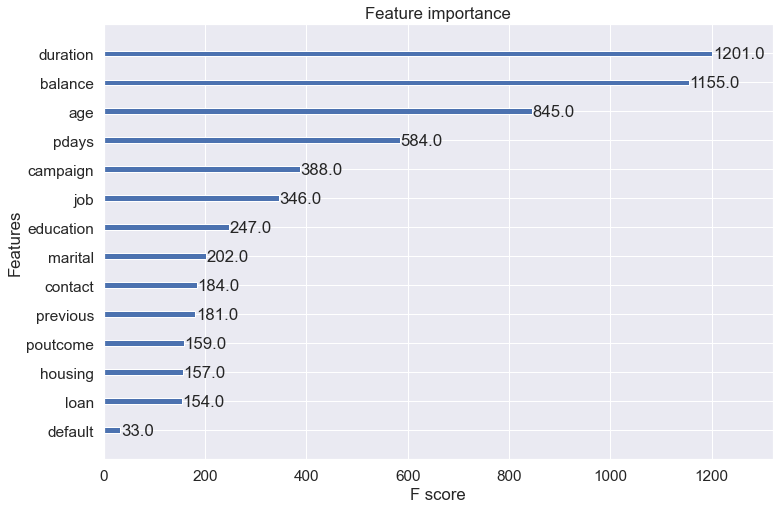

In [801]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(xgb_model, (12,8))
plt.show()

# Logistic Regression

In [755]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.98      0.89      0.94      3482
         1.0       0.17      0.57      0.26       136

    accuracy                           0.88      3618
   macro avg       0.58      0.73      0.60      3618
weighted avg       0.95      0.88      0.91      3618



# Random Forest

In [756]:
rfclass = RandomForestClassifier(n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced')

rfclass.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50,
                       n_jobs=-1, random_state=0)

In [758]:
predictions_randomforest = rfclass.predict(X_test) 
print (classification_report(y_test, predictions_randomforest))

              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88      3171
         1.0       0.38      0.81      0.52       447

    accuracy                           0.81      3618
   macro avg       0.67      0.81      0.70      3618
weighted avg       0.90      0.81      0.84      3618



# Decision Tree

In [759]:
dtree_model = DecisionTreeClassifier()
dtree_model.fit(X_train, y_train)

y_pred = dtree_model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      3204
         1.0       0.39      0.42      0.41       414

    accuracy                           0.86      3618
   macro avg       0.66      0.67      0.66      3618
weighted avg       0.86      0.86      0.86      3618



# Support Vector Machines

In [760]:
# svc = SVC()
# svc.fit(X_train, y_train)
# y_pred = svc.predict(X_test)
# print(classification_report(y_pred,y_test))

# KNeighborsClassifier

In [761]:
# knn = KNeighborsClassifier(n_neighbors = 3)
# knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)
# print(classification_report(y_pred,y_test))

# Gaussian Naive Bayes

In [762]:
# gaussian = GaussianNB()
# gaussian.fit(X_train, y_train)
# y_pred = gaussian.predict(X_test)
# print(classification_report(y_pred,y_test))

# Perceptron 

In [763]:
# perceptron = Perceptron()
# perceptron.fit(X_train, y_train)
# y_pred = perceptron.predict(X_test)
# print(classification_report(y_pred,y_test))

# Linear SVC

In [764]:
# linear_svc = LinearSVC()
# linear_svc.fit(X_train, y_train)
# y_pred = linear_svc.predict(X_test)
# print(classification_report(y_pred,y_test))

# Stochastic Gradient Descent

In [765]:
# sgd = SGDClassifier()
# sgd.fit(X_train, y_train)
# y_pred = sgd.predict(X_test)
# print(classification_report(y_pred,y_test))